Using device: cuda
--- Phase 1: Adam Optimization ---


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Adam Epoch     0 | Total Loss = 7.093e+02 | PDE loss = 5.693e+02 | BC loss = 1.400e+00
Adam Epoch   500 | Total Loss = 5.541e+01 | PDE loss = 5.507e+01 | BC loss = 3.366e-03
Adam Epoch  1000 | Total Loss = 3.615e+01 | PDE loss = 3.597e+01 | BC loss = 1.823e-03
Adam Epoch  1500 | Total Loss = 2.987e+01 | PDE loss = 2.975e+01 | BC loss = 1.213e-03
Adam Epoch  2000 | Total Loss = 2.048e+01 | PDE loss = 2.043e+01 | BC loss = 4.296e-04
Adam Epoch  2500 | Total Loss = 1.728e+01 | PDE loss = 1.724e+01 | BC loss = 4.275e-04
Adam Epoch  3000 | Total Loss = 1.416e+01 | PDE loss = 1.411e+01 | BC loss = 4.082e-04
Adam Epoch  3500 | Total Loss = 1.227e+01 | PDE loss = 1.223e+01 | BC loss = 3.696e-04
Adam Epoch  4000 | Total Loss = 8.789e+00 | PDE loss = 8.750e+00 | BC loss = 3.873e-04
Adam Epoch  4500 | Total Loss = 6.768e+00 | PDE loss = 6.729e+00 | BC loss = 3.876e-04
Adam Epoch  5000 | Total Loss = 5.489e+00 | PDE loss = 5.447e+00 | BC loss = 4.253e-04
Adam Epoch  5500 | Total Loss = 4.770e+00 |

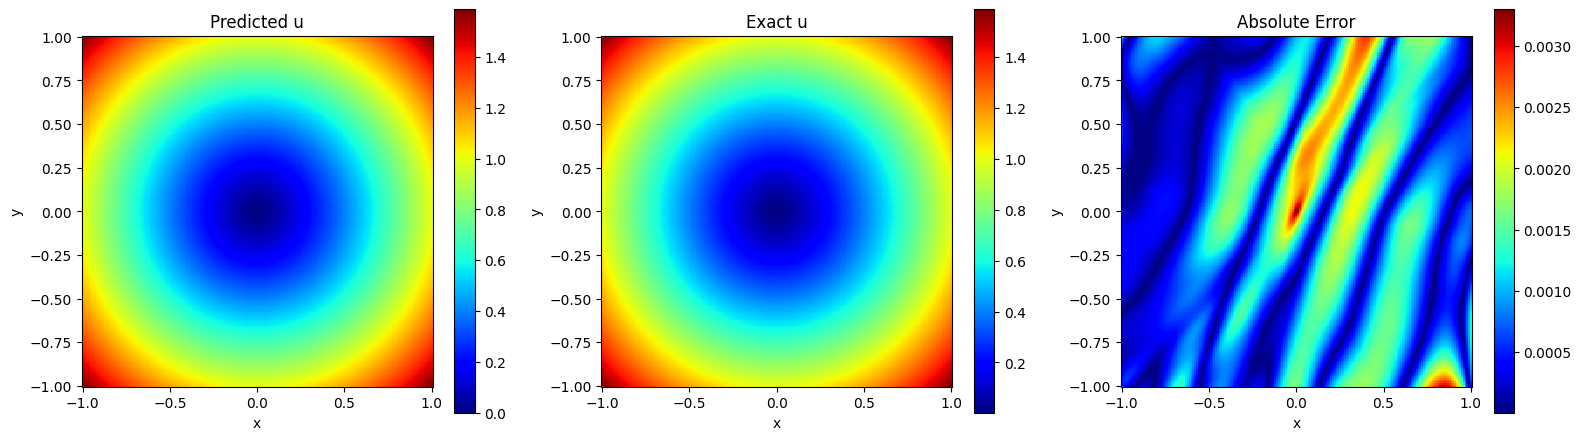

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time

# ======================
# 1. 基本设置 (无变化)
# ======================
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 训练区域 [-1, 1]^2
lb = torch.tensor([-1.0, -1.0]).to(device)
ub = torch.tensor([1.0, 1.0]).to(device)

# 各向异性系数矩阵 A
A = torch.tensor([[1.0, 2.0],
                  [2.0, 5.0]], dtype=torch.float64).to(device)

# ======================
# 2. 精确解与右端项 (无变化)
# ======================
def u_exact(x, y):
    # 添加一个极小的 epsilon 防止 x,y 同时为 0 时出现 nan
    eps = 1e-8
    return (x**2 + y**2 + eps)**(2/3)

def f_exact(x, y):
    # 添加一个极小的 epsilon 防止 x,y 同时为 0 时出现 nan
    eps = 1e-8
    return 32 * (2*x**2 + y**2 - x*y) / (9 * (x**2 + y**2 + eps)**(4/3))

# ======================
# 3. PINN 网络结构 (修改)
# ======================
# 2. 简化网络结构: 减少层宽和层数，降低参数量，可能加速收敛
# 原网络: [2, 128, 128, 128, 1]
# 新网络: [2, 64, 64, 64, 1]
class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for i in range(len(self.layers)-1):
            x = self.activation(self.layers[i](x))
        return self.layers[-1](x)

# 网络配置
layers = [2, 64, 64, 64, 1]
model = MLP(layers).to(device)

# ======================
# 4. 物理残差定义 (无变化)
# ======================
def pde_residual(xy, model_instance):
    xy.requires_grad_(True)
    u = model_instance(xy)

    grads = torch.autograd.grad(u, xy, torch.ones_like(u), create_graph=True)[0]
    ux = grads[:, 0:1]
    uy = grads[:, 1:2]

    # A∇u
    Agrad = torch.cat([A[0,0]*ux + A[0,1]*uy,
                       A[1,0]*ux + A[1,1]*uy], dim=1)

    div_term = []
    for i in range(2):
        grad_Aui = torch.autograd.grad(Agrad[:, i], xy, torch.ones_like(Agrad[:, i]), create_graph=True)[0]
        div_term.append(grad_Aui[:, i:i+1])
    div_Agrad = sum(div_term)

    f_val = f_exact(xy[:, 0:1], xy[:, 1:2])
    return div_Agrad - f_val

# ======================
# 5. 采样点 (修改)
# ======================
# 3. 强化采样策略
def sample_interior_enhanced(n, epsilon=1e-4):
    """
    在内部采样，但在原点附近进行加密采样，同时严格避开奇点 (0,0)。
    - n_dense: 在半径为 r_dense 的小圆内密集采样的点数
    - n_sparse: 在剩余区域采样的点数
    """
    n_dense = int(n * 0.7)  # 70% 的点用于密集区域
    n_sparse = n - n_dense
    r_dense = 0.2 # 定义密集采样区域的半径

    # (1) 密集区域采样 (环形区域)
    # 在 [epsilon, r_dense] 内采样，避免奇点
    theta = 2 * np.pi * torch.rand(n_dense, 1, device=device, dtype=torch.float64)
    # 通过开方使r的分布更均匀地覆盖面积
    r = torch.sqrt(torch.rand(n_dense, 1, device=device, dtype=torch.float64) * (r_dense**2 - epsilon**2) + epsilon**2)
    x_dense = r * torch.cos(theta)
    y_dense = r * torch.sin(theta)
    xy_dense = torch.cat([x_dense, y_dense], dim=1)

    # (2) 稀疏区域采样 (矩形减去中心圆)
    xy_sparse = torch.zeros((n_sparse, 2), device=device, dtype=torch.float64)
    count = 0
    while count < n_sparse:
        # 在整个 [-1,1]^2 区域随机采样
        xy_candidate = lb + (ub - lb) * torch.rand(n_sparse, 2, device=device, dtype=torch.float64)
        # 计算到原点的距离
        dist_from_origin = torch.sqrt(xy_candidate[:,0]**2 + xy_candidate[:,1]**2)
        # 保留密集区域外的点
        mask = dist_from_origin > r_dense
        valid_points = xy_candidate[mask]

        num_valid = valid_points.shape[0]
        if num_valid > 0:
            take_num = min(num_valid, n_sparse - count)
            xy_sparse[count:count+take_num, :] = valid_points[:take_num, :]
            count += take_num

    return torch.cat([xy_dense, xy_sparse], dim=0)


def sample_boundary(n_per_edge):
    """
    在四条边上均匀采样，增加边界点数量以强化约束。
    """
    # top and bottom edges
    x_tb = torch.linspace(-1, 1, n_per_edge, device=device, dtype=torch.float64).view(-1, 1)
    y_top = torch.ones_like(x_tb)
    y_bottom = -torch.ones_like(x_tb)
    xy_top = torch.cat([x_tb, y_top], dim=1)
    xy_bottom = torch.cat([x_tb, y_bottom], dim=1)

    # left and right edges (excluding corners already included)
    y_lr = torch.linspace(-1, 1, n_per_edge, device=device, dtype=torch.float64)[1:-1].view(-1, 1)
    x_left = -torch.ones_like(y_lr)
    x_right = torch.ones_like(y_lr)
    xy_left = torch.cat([x_left, y_lr], dim=1)
    xy_right = torch.cat([x_right, y_lr], dim=1)

    xb = torch.cat([xy_top, xy_bottom, xy_left, xy_right], dim=0)
    ub_val = u_exact(xb[:,0:1], xb[:,1:2])
    return xb, ub_val

# ======================
# 6. 训练逻辑 (核心修改)
# ======================
# 采样点和权重
N_f = 4000  # 增加内部点
N_b_per_edge = 401 # 增加边界点, 总共 401*4 - 4 = 1600 个点
lambda_bc = 100.0

# ---- 第一阶段：Adam 优化 ----
print("--- Phase 1: Adam Optimization ---")
optimizer_adam = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_adam, step_size=2000, gamma=0.5)
adam_epochs = 8000

# 预先采样固定的点用于 Adam 训练（也可以在循环内采样）
xy_f_adam = sample_interior_enhanced(N_f).to(device)
xy_b_adam, u_b_adam = sample_boundary(N_b_per_edge)
xy_b_adam, u_b_adam = xy_b_adam.to(device), u_b_adam.to(device)


for epoch in range(adam_epochs):
    optimizer_adam.zero_grad()

    res = pde_residual(xy_f_adam, model)
    loss_pde = torch.mean(res**2)

    u_pred_b = model(xy_b_adam)
    loss_bc = torch.mean((u_pred_b - u_b_adam)**2)

    loss = loss_pde + lambda_bc * loss_bc

    loss.backward()
    optimizer_adam.step()
    scheduler.step()

    if epoch % 500 == 0:
        print(f"Adam Epoch {epoch:5d} | Total Loss = {loss.item():.3e} | PDE loss = {loss_pde.item():.3e} | BC loss = {loss_bc.item():.3e}")

# ---- 第二阶段：L-BFGS 优化 ----
# 1. 实现 L-BFGS 优化器逻辑
print("\n--- Phase 2: L-BFGS Optimization ---")
optimizer_lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,  # L-BFGS 的学习率通常设为 1
    max_iter=50000, # L-BFGS 自身的迭代次数
    max_eval=50000,
    history_size=50,
    line_search_fn="strong_wolfe"  # 使用强 Wolfe 线搜索
)

# L-BFGS 需要一个闭包函数，该函数重新计算损失并返回它
def closure():
    optimizer_lbfgs.zero_grad()

    # 在每个 L-BFGS 评估步骤中，可以使用相同的采样点
    # 或者重新采样以获得更好的泛化性。这里我们使用 Adam 训练后的点集。
    res = pde_residual(xy_f_adam, model)
    loss_pde = torch.mean(res**2)

    u_pred_b = model(xy_b_adam)
    loss_bc = torch.mean((u_pred_b - u_b_adam)**2)

    loss = loss_pde + lambda_bc * loss_bc

    loss.backward()

    # 打印 L-BFGS 内部的迭代信息
    global lbfgs_iter
    if lbfgs_iter % 100 == 0:
        print(f"L-BFGS Iter {lbfgs_iter:5d} | Total Loss = {loss.item():.3e} | PDE loss = {loss_pde.item():.3e} | BC loss = {loss_bc.item():.3e}")
    lbfgs_iter += 1

    return loss

# 4. 调用 L-BFGS 优化器
global lbfgs_iter
lbfgs_iter = 0
optimizer_lbfgs.step(closure)


# ======================
# 7. 可视化与误差计算 (无变化)
# ======================
print("\n--- Evaluating Final Model ---")
x = np.linspace(-1, 1, 201)
y = np.linspace(-1, 1, 201)
X, Y = np.meshgrid(x, y)
XY = torch.tensor(np.vstack((X.flatten(), Y.flatten())).T, dtype=torch.float64).to(device)

with torch.no_grad():
    U_pred = model(XY).cpu().numpy().reshape(X.shape)
    U_true_grid = u_exact(torch.from_numpy(X), torch.from_numpy(Y)).numpy()
    error = np.abs(U_pred - U_true_grid)

# 计算 L2 相对误差
l2_error = np.linalg.norm(U_pred - U_true_grid) / np.linalg.norm(U_true_grid)
print(f"Final Relative L2 Error: {l2_error:.3e}")


plt.figure(figsize=(16, 4.5))
plt.subplot(1, 3, 1)
plt.title("Predicted u")
plt.pcolormesh(X, Y, U_pred, shading='auto', cmap='jet')
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.axis('square')


plt.subplot(1, 3, 2)
plt.title("Exact u")
plt.pcolormesh(X, Y, U_true_grid, shading='auto', cmap='jet')
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.axis('square')


plt.subplot(1, 3, 3)
plt.title("Absolute Error")
plt.pcolormesh(X, Y, error, shading='auto', cmap='jet')
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.axis('square')


plt.tight_layout()
plt.show()